In [1]:
%load_ext autoreload
%autoreload 2
import warnings

warnings.simplefilter(action="ignore")
import pandas as pd
import numpy as np
from scipy import sparse
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import patches
import matplotlib.colors as colors
import pickle
import textwrap
import re
import draw_cartel
import sys, os
import utils

import nltk

nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /Users/skojaku-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/skojaku-
[nltk_data]     admin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def calc_frac_citations_from_group(cartel, A):

    nodes = cartel.node_id.values
    indeg = np.array(A.sum(axis=0)).reshape(-1)
    outdeg = np.array(A.sum(axis=1)).reshape(-1)
    As = A[nodes, :][:, nodes].toarray()
    As = As - np.diag(np.diag(As))

    recipient = np.array(np.sum(As, axis=0)).reshape(-1) / np.maximum(1.0, indeg[nodes])
    donor = np.array(np.sum(As, axis=1)).reshape(-1) / np.maximum(1.0, outdeg[nodes])
    return recipient



def load_sampled_cartel(net_data_dir, cartel_dir, sampled_cartel_file):
    # Load journal names
    journal_names = pd.read_csv("%s/journal_names.csv" % net_data_dir, sep="\t")

    # Load the cartels in each category
    df_sampled = pd.read_csv(sampled_cartel_file, sep="\t")
    df_2019 = utils.load_detected_cartels([2019], cartel_dir)
    
    sampled_cartel = []
    sampled_cartel = [(r["group_id"], r["year"]) for i, r in df_sampled.iterrows()] 
    sampled_cartel+= [(r["group_id"], r["year"]) for i, r in df_2019.iterrows()] 
    
    
    retval = []
    
    
    
    
    for _, row in df_sampled.iterrows():

        group_id = row["group_id"]
        year = row["year"]

        cartel = utils.load_detected_cartels([year], cartel_dir)
        cartel = cartel[cartel.group_id == group_id]
        A, Araw, nodes = utils.load_network(year, net_data_dir)

        recipient = calc_frac_citations_from_group(cartel, A)
        cartel.loc[cartel.index, "recipient_score_all"] = recipient
        cartel = pd.merge(
            cartel,
            journal_names,
            left_on="mag_journal_id",
            right_on="mag_journal_id",
            how="left",
        )
        retval += [{"cartel": cartel, "A": A}]

    order = [4, 1, 3, 0, 2]
    retval = [retval[i] for i in order]

    # Load the cartels that are detected in 2019
    year = 2019
    cartel_table = utils.load_detected_cartels([year], cartel_dir)
    A, Araw, nodes = utils.load_network(year, net_data_dir)

    # Compute the recipient score using the general citations
    for cid, cartel in cartel_table.groupby("group_id"):
        recipient = calc_frac_citations_from_group(cartel, A)
        cartel.loc[:, "recipient_score_all"] = recipient
        cartel = pd.merge(
            cartel,
            journal_names,
            left_on="mag_journal_id",
            right_on="mag_journal_id",
            how="left",
        )
        retval += [{"cartel": cartel, "A": A}]

    return retval


NET_DATA_DIR = "../../data/networks"
CARTEL_DIR = "../../data/cartels"
SAMPLED_CARTEL_FILE = "../../data/classified-cartels/case-study-cartels.csv"

cartel_list = load_sampled_cartel(NET_DATA_DIR, CARTEL_DIR, SAMPLED_CARTEL_FILE)

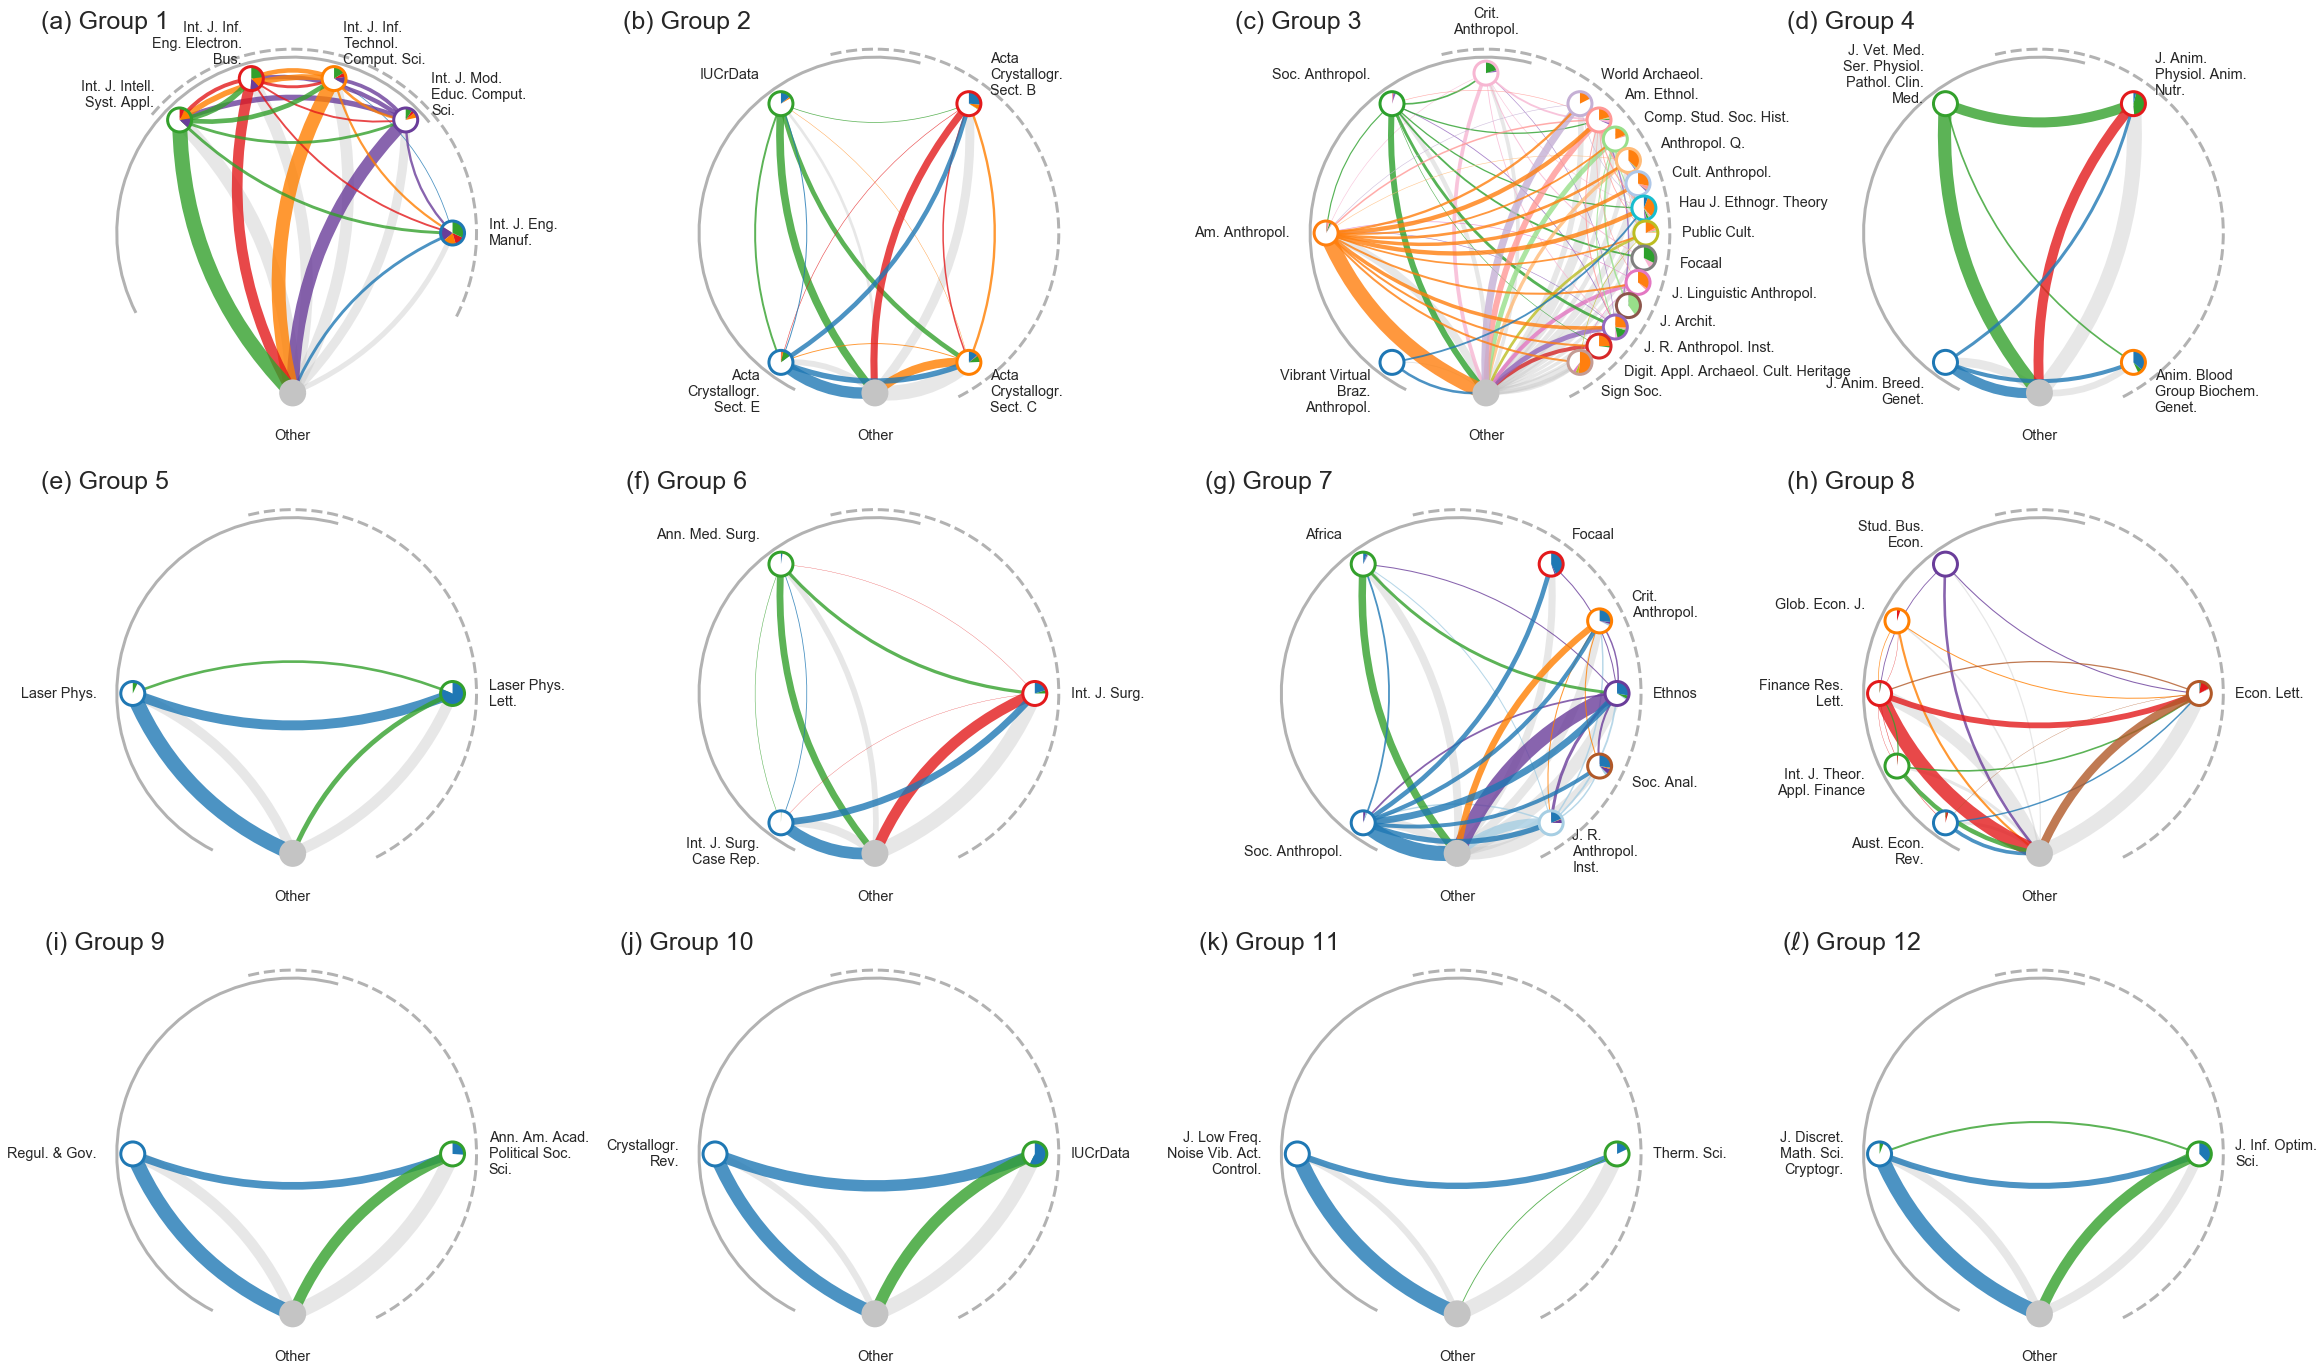

In [3]:
# Drawing setting
dc = draw_cartel.DrawCartel()
dc.node_size = 0.15
dc.font_scale = 1.2
dc.theta_1 = np.pi * 0.7
dc.angle_margin = 2 * np.pi / 30
dc.label_width = 15
dc.max_label_width = 18
sns.set_style("white")
sns.set_style("ticks")


figid = 0
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(40, 24))
subcap = ["a", "b", "c", "d", "e", "f", "g", "h", "i", "j", "k", "$\ell$"]
#
# Plot cartel in 2017
#
year = 2019
threshold = 0.15
gid = 0

for cid, cartel_A in enumerate(cartel_list):
    cartel = cartel_A["cartel"]
    A = cartel_A["A"]

    ax = axes.flat[figid]
    # ax = axes[gid, yid]
    # ax = axes[yid, gid]
    figid += 1
    gid += 1

    # classify nodes
    node_type, node_name = draw_cartel.classify_nodes(cartel, threshold)

    if cartel.shape[0] > 20:
        dc.node_size = 0.08
        dc.font_scale = 0.95
        dc.label_node_margin = 0.4  # 0.3
    else:
        dc.font_scale = 1.2
        dc.node_size = 0.15
        dc.label_node_margin = 0.45  # 0.31

    dc.draw(
        A,
        cartel.node_id.values,
        node_type,
        node_name,
        cartel.recipient_score_all.values,
        ax=ax,
    )
    ax.text(
        0.01,
        1.05,
        "({alph}) Group {id}".format(alph=subcap[figid - 1], id=figid),
        ha="center",
        va="center",
        transform=ax.transAxes,
        fontsize=25,
    )
    # ax.text(-0.15, 0.98,"({alph}) Group {id}".format(alph = subcap[figid-1], id=figid), ha='center', va='center', transform=ax.transAxes, fontsize=25)
    # if gid==1 :
    #    ax.text(0.5, 1.1,"Year %d" % year, ha='center', va='center', transform=ax.transAxes, fontsize=25)
    # ax.set_title("Year %d" % year, fontsize = 25)
    # ax.text(-0.15, 0.98,"(%s)" % subcap[figid-1], ha='center', va='center', transform=ax.transAxes, fontsize=28)

# Manual Trim
box = axes[0, 2].get_position()
box.x0 = box.x0 + 0.01
box.x1 = box.x1 + 0.01
axes[0, 2].set_position(box)
box = axes[1, 2].get_position()
box.x0 = box.x0 - 0.0
box.x1 = box.x1 - 0.0
axes[1, 2].set_position(box)

# box = axes[0,2].get_position()
# box.x0 = box.x0
# box.x1 = box.x1
# axes[0,2].set_position(box)

# box = axes[0,3].get_position()
# box.x0 = box.x0 - 0.02
# box.x1 = box.x1 - 0.02
# axes[0,3].set_position(box)

# box = axes[1,1].get_position()
# box.x0 = box.x0 + 0.01
# box.x1 = box.x1 + 0.01
# axes[1,1].set_position(box)

# axes[1,2].axis("off")
# axes[1,3].axis("off")
# fig.subplots_adjust(hspace=0.1)
fig.savefig("cartels.pdf", bbox_inches="tight")
plt.show()